# 1 使用BDMLtools做策略分析报告 <font size=3 >by 曾珂</font>

**环境**:
+ **OS**: macOS Big Sur 11.5.2
+ **CPU**: 2GHz 四核Intel Core i5
+ **内存**: 16G

In [1]:
import BDMLtools as bm
import pandas as pd
import numpy as np

In [2]:
bm.__version__

'0.2.8'

+ load germancredit data

In [3]:
import scorecardpy as sc
dt=sc.germancredit().copy()
dt['creditability']=dt['creditability'].map({'good':0,'bad':1})

+ 将germancredit的数据类型进行指定
    + num列-->float64
    + str列-->object
    + date列-->datetime

In [4]:
dtypes_dict={
    'num':['age.in.years',
         'credit.amount',
         'creditability',
         'duration.in.month',
         'installment.rate.in.percentage.of.disposable.income',
         'number.of.existing.credits.at.this.bank',
         'number.of.people.being.liable.to.provide.maintenance.for',
         'present.residence.since'],
    'str':['housing','telephone','foreign.worker','purpose','job','personal.status.and.sex','property',
           'credit.history','savings.account.and.bonds','present.employment.since',
           'status.of.existing.checking.account',
           'other.installment.plans','other.debtors.or.guarantors'],
    'date':[]
}

In [5]:
da=bm.dtypeAllocator(dtypes_dict=dtypes_dict).fit(dt)
dt=da.transform(dt)
X=dt.drop('creditability',axis=1)
y=dt['creditability']

## 1.1 BDMLtools中的报告

实践进行策略分析时，有时希望快速生成策略特征的分析报告,BDMLtools提供了三种特征分析库:
    
+ varReport:特征分析报告
+ varReportSinge:单特征分析报告
+ varGroupsReport:组特征分析报告

## 1.2 varReport

### 1.2.1 基本用法

一般特征分析需先进行分箱再生成报告,这里使用binSelector进行最优分箱

In [6]:
bin_tree=bm.binSelector(method='tree',bin_num_limit=5,n_jobs=1,iv_limit=0,coerce_monotonic=True).fit(X,y)

+ bin_tree中的属性breaks_list为分箱字典,包含了所有特征的分箱结果,格式与scorecardpy一致
+ 将breaks_list作为varReport的入参以按照指定的breaks_list分箱产生特征分析报告

In [7]:
vtab=bm.varReport(bin_tree.breaks_list,n_jobs=1).fit(X,y)

+ vtab的var_report_dict保存了所有特征的分箱结果,结构与scorecardpy一致

In [8]:
vtab.var_report_dict.keys()

dict_keys(['age.in.years', 'credit.amount', 'credit.history', 'duration.in.month', 'foreign.worker', 'housing', 'installment.rate.in.percentage.of.disposable.income', 'job', 'number.of.existing.credits.at.this.bank', 'number.of.people.being.liable.to.provide.maintenance.for', 'other.debtors.or.guarantors', 'other.installment.plans', 'personal.status.and.sex', 'present.employment.since', 'present.residence.since', 'property', 'purpose', 'savings.account.and.bonds', 'status.of.existing.checking.account', 'telephone'])

In [9]:
vtab.var_report_dict['credit.amount']

,variable,count,count_distr,good,bad,badprob,woe,bin_iv,total_iv,ks,ks_max,breaks
bin,,,,,,,,,,,,
"[-inf, 4000.0)",credit.amount,754,0.754,559,195,0.258621,-0.205852,0.030584,0.141682,0.148571,0.148571,4000.0
"[4000.0, 6800.0)",credit.amount,133,0.133,83,50,0.375940,0.340480,0.016375,0.141682,0.100476,0.148571,6800.0
"[6800.0, 9200.0)",credit.amount,63,0.063,37,26,0.412698,0.494476,0.016718,0.141682,0.066667,0.148571,9200.0
"[9200.0, inf)",credit.amount,50,0.050,21,29,0.580000,1.170071,0.078005,0.141682,0.000000,0.148571,inf
special,credit.amount,0,0.000,0,0,NaN,0.000000,0.000000,0.141682,0.000000,0.148571,special
missing,credit.amount,0,0.000,0,0,NaN,0.000000,0.000000,0.141682,0.000000,0.148571,missing


这里每一个报表中bin索引,
+ 存在missing行用于标示缺失值,数据中的np.nan将被计算进缺失值行中,若数据没有缺失值则为默认值
+ special行用于标示除缺失值外的特殊编码,可通过special_values参数进行指定,若数据没有特殊值则为默认值,详情请见文档

In [10]:
pd.concat(vtab.var_report_dict)

variable  \
                                    bin                                                                             
age.in.years                        [-inf, 26.0)                                                     age.in.years   
                                    [26.0, 30.0)                                                     age.in.years   
                                    [30.0, 35.0)                                                     age.in.years   
                                    [35.0, inf)                                                      age.in.years   
                                    special                                                          age.in.years   
...                                                                                                           ...   
status.of.existing.checking.account missing                                   status.of.existing.checking.account   
telephone                           yes, registered under the customers name                            telephone   
                                    none                                                                telephone   
                                    special                                                             telephone   
                                    missing                                                             telephone   

                                                                              count  \
                                    bin                                               
age.in.years                        [-inf, 26.0)                                190   
                                    [26.0, 30.0)                                181   
                                    [30.0, 35.0)                                177   
                                    [35.0, inf)                                 452   
                                    special                                       0   
...                                                                             ...   
status.of.existing.checking.account missing                                       0   
telephone                           yes, registered under the customers name    404   
                                    none                                        596   
                                    special                                       0   
                                    missing                                       0   

                                                                              count_distr  \
                                    bin                                                     
age.in.years                        [-inf, 26.0)                                    0.190   
                                    [26.0, 30.0)                                    0.181   
                                    [30.0, 35.0)                                    0.177   
                                    [35.0, inf)                                     0.452   
                                    special                                         0.000   
...                                                                                   ...   
status.of.existing.checking.account missing                                         0.000   
telephone                           yes, registered under the customers name        0.404   
                                    none                                            0.596   
                                    special                                         0.000   
                                    missing                                         0.000   

                                                                              good  \
                                    bin                                              
age.in.years                        [-inf, 26.0)                     

使用pd.concat形成所有特征的特征分析报告,与scorecardpy一致

### 1.2.2 样本权重

若数据是经过抽样获取的，一般希望通过样本加权建模以利于还原其违约概率

+ 加入样本权重后各个分箱的坏样本率会产生一定变化
+ 加入样本权重后各个分箱的iv,ks也会产生变化(若只对好坏样本加权且breaks一致则无变化,因为好坏分布未变化)

BDMLtools的报告支持加入样本权重

In [11]:
sample_weight=pd.Series(y.map({0:10,1:1}),index=y.index) #假定数据经过抽样后好样本权重为10,坏样本权重为1
sample_weight_oth=pd.Series(np.random.randint(0,100,y.size)/100,index=y.index) #模拟复杂抽样情形下的样本权重

In [12]:
vtab_ws=bm.varReport(bin_tree.breaks_list,n_jobs=1,sample_weight=sample_weight).fit(X,y)
vtab_ws_oth=bm.varReport(bin_tree.breaks_list,n_jobs=1,sample_weight=sample_weight_oth).fit(X,y)

In [13]:
vtab_ws.var_report_dict['credit.amount'] #加权后(仅类加权)

,variable,count,count_distr,good,bad,badprob,woe,bin_iv,total_iv,ks,ks_max,breaks
bin,,,,,,,,,,,,
"[-inf, 4000.0)",credit.amount,5785,0.792466,5590,195,0.033708,-0.205852,0.030584,0.141682,0.148571,0.148571,4000.0
"[4000.0, 6800.0)",credit.amount,880,0.120548,830,50,0.056818,0.340480,0.016375,0.141682,0.100476,0.148571,6800.0
"[6800.0, 9200.0)",credit.amount,396,0.054247,370,26,0.065657,0.494476,0.016718,0.141682,0.066667,0.148571,9200.0
"[9200.0, inf)",credit.amount,239,0.032740,210,29,0.121339,1.170071,0.078005,0.141682,0.000000,0.148571,inf
special,credit.amount,0,0.000000,0,0,NaN,0.000000,0.000000,0.141682,0.000000,0.148571,special
missing,credit.amount,0,0.000000,0,0,NaN,0.000000,0.000000,0.141682,0.000000,0.148571,missing


In [14]:
vtab_ws_oth.var_report_dict['credit.amount'] #加权后(样本加权)

,variable,count,count_distr,good,bad,badprob,woe,bin_iv,total_iv,ks,ks_max,breaks
bin,,,,,,,,,,,,
"[-inf, 4000.0)",credit.amount,380.17,0.753573,278.00,102.17,0.268748,-0.201124,0.029266,0.118743,0.145513,0.145513,4000.0
"[4000.0, 6800.0)",credit.amount,66.01,0.130845,38.93,27.08,0.410241,0.436889,0.026772,0.118743,0.084234,0.145513,6800.0
"[6800.0, 9200.0)",credit.amount,31.70,0.062836,18.57,13.13,0.414196,0.453211,0.013863,0.118743,0.053645,0.145513,9200.0
"[9200.0, inf)",credit.amount,26.61,0.052746,12.57,14.04,0.527621,0.910456,0.048841,0.118743,0.000000,0.145513,inf
special,credit.amount,0.00,0.000000,0.00,0.00,NaN,0.000000,0.000000,0.118743,0.000000,0.145513,special
missing,credit.amount,0.00,0.000000,0.00,0.00,NaN,0.000000,0.000000,0.118743,0.000000,0.145513,missing


In [15]:
vtab.var_report_dict['credit.amount'] #未加权

,variable,count,count_distr,good,bad,badprob,woe,bin_iv,total_iv,ks,ks_max,breaks
bin,,,,,,,,,,,,
"[-inf, 4000.0)",credit.amount,754,0.754,559,195,0.258621,-0.205852,0.030584,0.141682,0.148571,0.148571,4000.0
"[4000.0, 6800.0)",credit.amount,133,0.133,83,50,0.375940,0.340480,0.016375,0.141682,0.100476,0.148571,6800.0
"[6800.0, 9200.0)",credit.amount,63,0.063,37,26,0.412698,0.494476,0.016718,0.141682,0.066667,0.148571,9200.0
"[9200.0, inf)",credit.amount,50,0.050,21,29,0.580000,1.170071,0.078005,0.141682,0.000000,0.148571,inf
special,credit.amount,0,0.000,0,0,NaN,0.000000,0.000000,0.141682,0.000000,0.148571,special
missing,credit.amount,0,0.000,0,0,NaN,0.000000,0.000000,0.141682,0.000000,0.148571,missing


### 1.2.3 并行

varReport使用joblib对列的报告生成进行了并行优化,
+ 当基础的数据量非常大列较多时可通过设定n_jobs=任务数进行并行以提高运行速度
+ 一般情况下建议n_jobs=1

In [56]:
#模拟较大大数据量,3w行1000个特征
X_big=pd.DataFrame(np.random.rand(30000,1000),columns=['f'+str(i) for i in range(1000)])
y_big=pd.Series(np.random.randint(0,2,30000),name='target')
breaks_list_big={col:[0.2,0.4,0.6,0.8] for col in X_big.columns}

In [59]:
%%time
res_p=bm.varReport(breaks_list_big,n_jobs=-1).fit(X_big,y_big) 

CPU times: user 826 ms, sys: 158 ms, total: 984 ms
Wall time: 5.49 s


In [60]:
%%time
res=bm.varReport(breaks_list_big,n_jobs=1).fit(X_big,y_big)

CPU times: user 16 s, sys: 213 ms, total: 16.2 s
Wall time: 16.5 s


### 1.2.4 批量的特征分析报告绘图 

实例varReport的方法woe_plot可以根据分箱结果进行批量的绘图并输出

In [19]:
vtab=bm.varReport(bin_tree.breaks_list,n_jobs=1).fit(X,y)

vtab_figs_dict=vtab.woe_plot(n_jobs=1)

geom_path: Each group consist of only one observation. Do you need to adjust the group aesthetic?


特征分析报告中若特征分箱后只有一箱，那么会产生以上警告信息，此类信息可忽略，字典对象vtab_figs_dict存储了报告绘图的输出

In [20]:
vtab_figs_dict

{'age.in.years': <Figure size 640x480 with 2 Axes>,
 'credit.amount': <Figure size 640x480 with 2 Axes>,
 'credit.history': <Figure size 640x480 with 2 Axes>,
 'duration.in.month': <Figure size 640x480 with 2 Axes>,
 'foreign.worker': <Figure size 640x480 with 2 Axes>,
 'housing': <Figure size 640x480 with 2 Axes>,
 'installment.rate.in.percentage.of.disposable.income': <Figure size 640x480 with 2 Axes>,
 'job': <Figure size 640x480 with 2 Axes>,
 'number.of.existing.credits.at.this.bank': <Figure size 640x480 with 2 Axes>,
 'number.of.people.being.liable.to.provide.maintenance.for': <Figure size 640x480 with 2 Axes>,
 'other.debtors.or.guarantors': <Figure size 640x480 with 2 Axes>,
 'other.installment.plans': <Figure size 640x480 with 2 Axes>,
 'personal.status.and.sex': <Figure size 640x480 with 2 Axes>,
 'present.employment.since': <Figure size 640x480 with 2 Axes>,
 'present.residence.since': <Figure size 640x480 with 2 Axes>,
 'property': <Figure size 640x480 with 2 Axes>,
 'purp

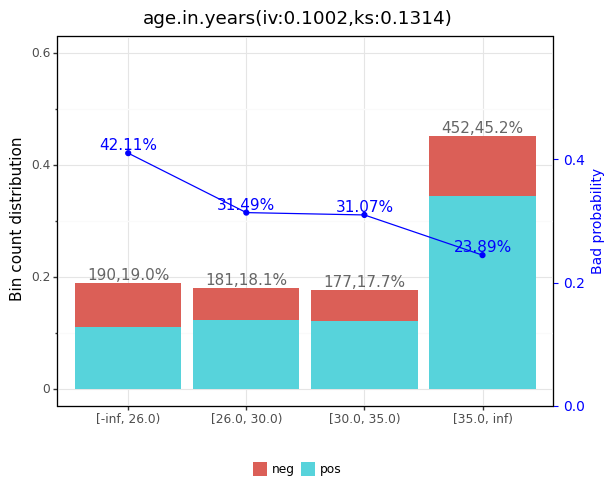

In [21]:
vtab_figs_dict['age.in.years']

BDMLtools使用plotnine作为绘图包产生woe_plot
+ plotnine作为ggplot2在python的实现，绘图语法与R的ggplot2一致
+ 特征分析报告中柱状图为各个bin好坏样本的count_dist
+ 特征分析报告中折线图为各个bin的坏样本率
+ 当前版本的作图基于plotnine-0.8，其不支持双轴图，因此坏样本率与count_dist目前共用一个y轴，在极端情况下(count_dist与坏样本率相差过大)的结果会不理想，BDMLtools将持续跟进plotnine的更新

## 1.3 varReportSinge

### 1.3.1 基本用法

对单一特征产生报告可用bm.varReportSinge,其可以灵活得调整分箱

In [22]:
bm.varReportSinge().report(X['age.in.years'],y,[26,30,35])

,variable,count,count_distr,good,bad,badprob,woe,bin_iv,total_iv,ks,ks_max,breaks
bin,,,,,,,,,,,,
"[-inf, 26.0)",age.in.years,190,0.190,110,80,0.421053,0.528844,0.057921,0.100182,0.109524,0.131429,26.0
"[26.0, 30.0)",age.in.years,181,0.181,124,57,0.314917,0.070068,0.000901,0.100182,0.122381,0.131429,30.0
"[30.0, 35.0)",age.in.years,177,0.177,122,55,0.310734,0.050610,0.000458,0.100182,0.131429,0.131429,35.0
"[35.0, inf)",age.in.years,452,0.452,344,108,0.238938,-0.311213,0.040902,0.100182,0.000000,0.131429,inf
special,age.in.years,0,0.000,0,0,NaN,0.000000,0.000000,0.100182,0.000000,0.131429,special
missing,age.in.years,0,0.000,0,0,NaN,0.000000,0.000000,0.100182,0.000000,0.131429,missing


In [23]:
bm.varReportSinge().report(X['age.in.years'],y,[26,35])

,variable,count,count_distr,good,bad,badprob,woe,bin_iv,total_iv,ks,ks_max,breaks
bin,,,,,,,,,,,,
"[-inf, 26.0)",age.in.years,190,0.190,110,80,0.421053,0.528844,0.057921,0.100148,0.109524,0.131429,26.0
"[26.0, 35.0)",age.in.years,358,0.358,246,112,0.312849,0.060465,0.001324,0.100148,0.131429,0.131429,35.0
"[35.0, inf)",age.in.years,452,0.452,344,108,0.238938,-0.311213,0.040902,0.100148,0.000000,0.131429,inf
special,age.in.years,0,0.000,0,0,NaN,0.000000,0.000000,0.100148,0.000000,0.131429,special
missing,age.in.years,0,0.000,0,0,NaN,0.000000,0.000000,0.100148,0.000000,0.131429,missing


### 1.3.2 样本权重

当然也支持样本权重

In [24]:
sample_weight=pd.Series(y.map({0:10,1:1}),index=y.index)
bm.varReportSinge().report(X['age.in.years'],y,[26,30,35],sample_weight)

,variable,count,count_distr,good,bad,badprob,woe,bin_iv,total_iv,ks,ks_max,breaks
bin,,,,,,,,,,,,
"[-inf, 26.0)",age.in.years,1180,0.161644,1100,80,0.067797,0.528844,0.057921,0.100182,0.109524,0.131429,26.0
"[26.0, 30.0)",age.in.years,1297,0.177671,1240,57,0.043948,0.070068,0.000901,0.100182,0.122381,0.131429,30.0
"[30.0, 35.0)",age.in.years,1275,0.174658,1220,55,0.043137,0.050610,0.000458,0.100182,0.131429,0.131429,35.0
"[35.0, inf)",age.in.years,3548,0.486027,3440,108,0.030440,-0.311213,0.040902,0.100182,0.000000,0.131429,inf
special,age.in.years,0,0.000000,0,0,NaN,0.000000,0.000000,0.100182,0.000000,0.131429,special
missing,age.in.years,0,0.000000,0,0,NaN,0.000000,0.000000,0.100182,0.000000,0.131429,missing


### 1.3.2 单特征分析报告绘图

方法woe_plot可支持绘制特征分析报告

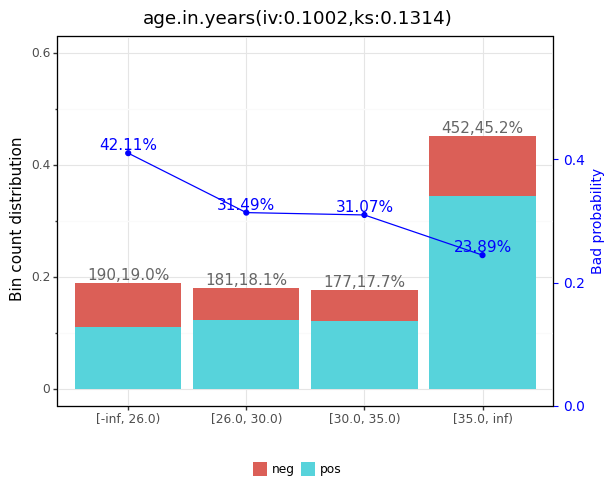

In [25]:
tab,fig,breaks=bm.varReportSinge().woe_plot(X['age.in.years'],y,[26,30,35],show_plot=True)

使用方法woe_plot进行单特征的分箱调整会更加直观与方便

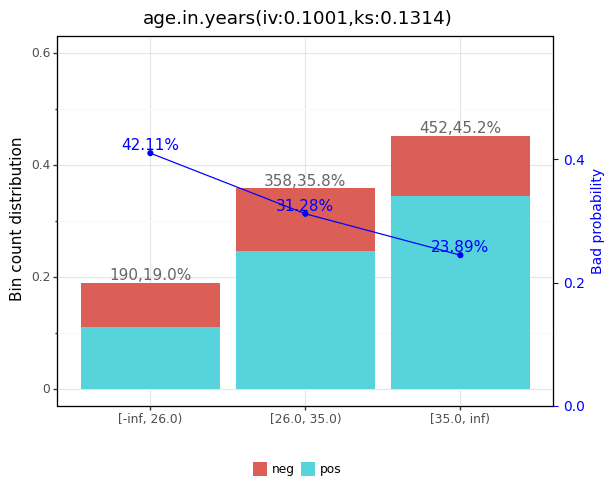

In [26]:
tab,fig,breaks=bm.varReportSinge().woe_plot(X['age.in.years'],y,[26,35],show_plot=True)

In [27]:
print(breaks)
print(tab)

[26, 35]
                  variable  count  count_distr  good  bad   badprob       woe  \
bin                                                                             
[-inf, 26.0)  age.in.years    190        0.190   110   80  0.421053  0.528844   
[26.0, 35.0)  age.in.years    358        0.358   246  112  0.312849  0.060465   
[35.0, inf)   age.in.years    452        0.452   344  108  0.238938 -0.311213   
special       age.in.years      0        0.000     0    0       NaN  0.000000   
missing       age.in.years      0        0.000     0    0       NaN  0.000000   

                bin_iv  total_iv        ks    ks_max   breaks  
bin                                                            
[-inf, 26.0)  0.057921  0.100148  0.109524  0.131429     26.0  
[26.0, 35.0)  0.001324  0.100148  0.131429  0.131429     35.0  
[35.0, inf)   0.040902  0.100148  0.000000  0.131429      inf  
special       0.000000  0.100148  0.000000  0.131429  special  
missing       0.000000  0.100148  0.000

## 1.4 varGroupsReport

在实践中,单一的特征分析报告往往仍旧无法满足实际需要,往往希望通过不同的月份\产品\客群查看各个策略的表现,那么就需要分组产生分析报告

varGroupsReport就是用来满足这种需要的

### 1.4.1 基本用法

In [28]:
#模拟月份(9,10,11,12月),模拟客群(3个)

X_all=X.join(y).assign(
    month=np.random.randint(9,13,y.size),
    client_group=pd.Series(np.random.randint(0,3,y.size),index=y.index).map({0:'g1',1:'g2',2:'g3'})
)

In [29]:
vtab_g=bm.varGroupsReport(bin_tree.breaks_list,columns=['month','client_group'],target=y.name,row_limit=0,
                          n_jobs=1).fit(X_all)

vtab_g中共五张报表:
+ report_all:各个组的特征报告
+ report_brief:各个组的简化版报告,只保留count,badprob,woe,total_iv,ks_max
+ report_count:各个组的简化版报告,只保留count
+ report_badprob:各个组的简化版报告,只保留badprob
+ report_iv:各个组的简化版报告,只保留total_iv
+ report_ks:各个组的简化版报告,只保留ks_max

以report_brief为例

In [30]:
vtab_g.report_dict['report_brief'][['variable','bin','10']] #只看10月份的报告

variable  \
                                           
                                           
0                           age.in.years   
1                           age.in.years   
2                           age.in.years   
3                           age.in.years   
4                           age.in.years   
..                                   ...   
101  status.of.existing.checking.account   
102                            telephone   
103                            telephone   
104                            telephone   
105                            telephone   

                                          bin    10                      \
                                                 g1                       
                                              count   badprob       woe   
0                                [-inf, 26.0)    13  0.615385  1.386294   
1                                [26.0, 30.0)    14  0.500000  0.916291   
2                                [30.0, 35.0)    12  0.083333 -1.481605   
3                                 [35.0, inf)    45  0.177778 -0.615186   
4                                     special     0       NaN  0.000000   
..                                        ...   ...       ...       ...   
101                                   missing     0       NaN  0.000000   
102  yes, registered under the customers name    35  0.200000 -0.470004   
103                                      none    49  0.346939  0.283768   
104                                   special     0       NaN  0.000000   
105                                   missing     0       NaN  0.000000   

                                                                           \
                        g2                                             g3   
     total_iv ks_max count   badprob        woe  total_iv    ks_max count   
0    0.891121  0.425    19  0.368421   0.231112  4.474956  0.195556    19   
1    0.891121  0.425    11  0.000000 -21.434762  4.474956  0.195556    14   
2    0.891121  0.425     9  0.222222  -0.482655  4.474956  0.195556    13   
3    0.891121  0.425    40  0.400000   0.364643  4.474956  0.195556    40   
4    0.891121  0.425     0       NaN   0.000000  4.474956  0.195556     0   
..        ...    ...   ...       ...        ...       ...       ...   ...   
101  1.287672  0.500     0       NaN   0.000000  0.789746  0.361481     0   
102  0.131910  0.175    31  0.387097   0.310576  0.068030  0.128148    36   
103  0.131910  0.175    48  0.270833  -0.220290  0.068030  0.128148    50   
104  0.131910  0.175     0       NaN   0.000000  0.068030  0.128148     0   
105  0.131910  0.175     0       NaN   0.000000  0.068030  0.128148     0   

                                             
                                             
      badprob       woe  total_iv    ks_max  
0    0.368421  0.353002  0.175540  0.204590  
1    0.357143  0.304211  0.175540  0.204590  
2    0.384615  0.421994  0.175540  0.204590  
3    0.200000 -0.494296  0.175540  0.204590  
4         NaN  0.000000  0.175540  0.204590  
..        ...       ...       ...       ...  
101       NaN  0.000000  0.862458  0.304262  
102  0.416667  0.555526  0.268479  0.255738  
103  0.200000 -0.494296  0.268479  0.255738  
104       NaN  0.000000  0.268479  0.255738  
105       NaN  0.000000  0.268479  0.255738  

[106 rows x 17 columns]

In [31]:
vtab_g.report_dict['report_brief'] #全部报告

variable  \
                                           
                                           
0                           age.in.years   
1                           age.in.years   
2                           age.in.years   
3                           age.in.years   
4                           age.in.years   
..                                   ...   
101  status.of.existing.checking.account   
102                            telephone   
103                            telephone   
104                            telephone   
105                            telephone   

                                          bin    10                      \
                                                 g1                       
                                              count   badprob       woe   
0                                [-inf, 26.0)    13  0.615385  1.386294   
1                                [26.0, 30.0)    14  0.500000  0.916291   
2                                [30.0, 35.0)    12  0.083333 -1.481605   
3                                 [35.0, inf)    45  0.177778 -0.615186   
4                                     special     0       NaN  0.000000   
..                                        ...   ...       ...       ...   
101                                   missing     0       NaN  0.000000   
102  yes, registered under the customers name    35  0.200000 -0.470004   
103                                      none    49  0.346939  0.283768   
104                                   special     0       NaN  0.000000   
105                                   missing     0       NaN  0.000000   

                                                 ...     9            \
                        g2                       ...    g2             
     total_iv ks_max count   badprob        woe  ... count   badprob   
0    0.891121  0.425    19  0.368421   0.231112  ...    17  0.705882   
1    0.891121  0.425    11  0.000000 -21.434762  ...    15  0.400000   
2    0.891121  0.425     9  0.222222  -0.482655  ...    20  0.250000   
3    0.891121  0.425    40  0.400000   0.364643  ...    39  0.179487   
4    0.891121  0.425     0       NaN   0.000000  ...     0       NaN   
..        ...    ...   ...       ...        ...  ...   ...       ...   
101  1.287672  0.500     0       NaN   0.000000  ...     0       NaN   
102  0.131910  0.175    31  0.387097   0.310576  ...    34  0.264706   
103  0.131910  0.175    48  0.270833  -0.220290  ...    57  0.368421   
104  0.131910  0.175     0       NaN   0.000000  ...     0       NaN   
105  0.131910  0.175     0       NaN   0.000000  ...     0       NaN   

                                                                       \
                                     g3                                 
          woe  total_iv    ks_max count   badprob       woe  total_iv   
0    1.585145  0.786866  0.370492    16  0.375000 -0.126414  0.202532   
1    0.304211  0.786866  0.370492    13  0.538462  0.538562  0.202532   
2   -0.388936  0.786866  0.370492    12  0.583333  0.720884  0.202532   
3   -0.810149  0.786866  0.370492    38  0.315789 -0.388778  0.202532   
4    0.000000  0.786866  0.370492     0       NaN  0.000000  0.202532   
..        ...       ...       ...   ...       ...       ...       ...   
101  0.000000  0.592677  0.308743     0       NaN  0.000000  2.482280   
102 -0.311975  0.053013  0.109836    30  0.333333 -0.308735  0.055199   
103  0.170680  0.053013  0.109836    49  0.448980  0.179617  0.055199   
104  0.000000  0.053013  0.109836     0       NaN  0.000000  0.055199   
105  0.000000  0.053013  0.109836     0       NaN  0.000000  0.055199   

               
               
       ks_max  
0    0.178191  
1    0.178191  
2    0.178191  
3    0.178191  
4    0.178191  
..        ...  
101  0.440824  
102  0.113032  
103  0.113032  
104  0.113032  
105  0.113032  

[106 rows x 62 columns]

In [32]:
vtab_g.report_dict['report_ks']

variable        10            \
                                                             g1        g2   
                                                         ks_max    ks_max   
0                                        age.in.years  0.425000  0.195556   
1                                       credit.amount  0.183333  0.199259   
2                                      credit.history  0.400000  0.202963   
3                                   duration.in.month  0.283333  0.185926   
4                                      foreign.worker  0.000000  0.000000   
5                                             housing  0.066667  0.137778   
6   installment.rate.in.percentage.of.disposable.i...  0.241667  0.148148   
7                                                 job  0.141667  0.190370   
8             number.of.existing.credits.at.this.bank  0.175000  0.007407   
9   number.of.people.being.liable.to.provide.maint...  0.150000  0.190370   
10                        other.debtors.or.guarantors  0.066667  0.042963   
11                            other.installment.plans  0.025000  0.137778   
12                            personal.status.and.sex  0.091667  0.112593   
13                           present.employment.since  0.125000  0.125185   
14                            present.residence.since  0.033333  0.025185   
15                                           property  0.191667  0.230370   
16                                            purpose  0.108333  0.199259   
17                          savings.account.and.bonds  0.133333  0.404444   
18                status.of.existing.checking.account  0.500000  0.361481   
19                                          telephone  0.175000  0.128148   

                    11                            12                      \
          g3        g1        g2        g3        g1        g2        g3   
      ks_max    ks_max    ks_max    ks_max    ks_max    ks_max    ks_max   
0   0.204590  0.090832  0.315942  0.087827  0.278571  0.108333  0.333333   
1   0.103607  0.174873  0.021256  0.221880  0.050000  0.039583  0.214286   
2   0.183607  0.125637  0.378744  0.287365  0.200000  0.143750  0.077381   
3   0.083934  0.163837  0.149758  0.394453  0.150000  0.282292  0.184524   
4   0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
5   0.316066  0.129881  0.146860  0.160247  0.059524  0.054167  0.011905   
6   0.151475  0.208829  0.056039  0.121726  0.111905  0.242708  0.035714   
7   0.116066  0.085739  0.126570  0.080894  0.128571  0.107292  0.017857   
8   0.017049  0.203735  0.226087  0.145609  0.009524  0.077083  0.031746   
9   0.083934  0.198642  0.003865  0.021572  0.007143  0.059375  0.101190   
10  0.041967  0.048387  0.023188  0.056240  0.030952  0.037500  0.063492   
11  0.068852  0.122241  0.236715  0.182589  0.045238  0.206250  0.091270   
12  0.078033  0.070458  0.206763  0.274268  0.128571  0.106250  0.063492   
13  0.266230  0.058574  0.257971  0.143297  0.147619  0.159375  0.079365   
14  0.140328  0.023769  0.020290  0.108629  0.009524  0.023958  0.101190   
15  0.238033  0.095076  0.099517  0.261941  0.107143  0.175000  0.087302   
16  0.184918  0.261460  0.115942  0.389060  0.152381  0.120833  0.309524   
17  0.131803  0.085739  0.335266  0.270416  0.195238  0.272917  0.255952   
18  0.304262  0.151952  0.427053  0.615562  0.302381  0.492708  0.361111   
19  0.255738  0.050934  0.162319  0.110940  0.064286  0.172917  0.123016   

           9                      
          g1        g2        g3  
      ks_max    ks_max    ks_max  
0   0.180556  0.370492  0.178191  
1   0.414931  0.203825  0.237367  
2   0.255208  0.291257  0.246676  
3   0.375000  0.259016  0.196144  
4   0.000000  0.000000  0.000000  
5   0.178819  0.221311  0.130984  
6   0.022569  0.122404  0.159574  
7   0.114583  0.163388  0.122340  
8   0.085069  0.174863  0.017952  
9   0.081597  0.129508  0.008644  
10  0.031250  0.015847  0.042553  
11  0.177083  0.013661  0.130984  

### 1.4.2 排序组特征水平

上述报告中,月份排序有一定问题,那么若希望以指定顺序排序报告则可通过sort_columns参数设定 

In [33]:
sort_columns={
    'month':['9','10','11','12'],
    'client_group':['g3','g2','g1']
} 

In [34]:
vtab_g=bm.varGroupsReport(bin_tree.breaks_list,columns=['month','client_group'],target=y.name,row_limit=0,
                          sort_columns=sort_columns,
                          n_jobs=1).fit(X_all)

In [35]:
vtab_g.report_dict['report_ks'] #排序后的数据

variable         9            \
                                                             g3        g2   
                                                         ks_max    ks_max   
0                                        age.in.years  0.178191  0.370492   
1                                       credit.amount  0.237367  0.203825   
2                                      credit.history  0.246676  0.291257   
3                                   duration.in.month  0.196144  0.259016   
4                                      foreign.worker  0.000000  0.000000   
5                                             housing  0.130984  0.221311   
6   installment.rate.in.percentage.of.disposable.i...  0.159574  0.122404   
7                                                 job  0.122340  0.163388   
8             number.of.existing.credits.at.this.bank  0.017952  0.174863   
9   number.of.people.being.liable.to.provide.maint...  0.008644  0.129508   
10                        other.debtors.or.guarantors  0.042553  0.015847   
11                            other.installment.plans  0.130984  0.013661   
12                            personal.status.and.sex  0.069149  0.159563   
13                           present.employment.since  0.273271  0.207650   
14                            present.residence.since  0.055186  0.002186   
15                                           property  0.120346  0.178142   
16                                            purpose  0.439495  0.160109   
17                          savings.account.and.bonds  0.121676  0.078142   
18                status.of.existing.checking.account  0.440824  0.308743   
19                                          telephone  0.113032  0.109836   

                    10                            11                      \
          g1        g3        g2        g1        g3        g2        g1   
      ks_max    ks_max    ks_max    ks_max    ks_max    ks_max    ks_max   
0   0.180556  0.204590  0.195556  0.425000  0.087827  0.315942  0.090832   
1   0.414931  0.103607  0.199259  0.183333  0.221880  0.021256  0.174873   
2   0.255208  0.183607  0.202963  0.400000  0.287365  0.378744  0.125637   
3   0.375000  0.083934  0.185926  0.283333  0.394453  0.149758  0.163837   
4   0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
5   0.178819  0.316066  0.137778  0.066667  0.160247  0.146860  0.129881   
6   0.022569  0.151475  0.148148  0.241667  0.121726  0.056039  0.208829   
7   0.114583  0.116066  0.190370  0.141667  0.080894  0.126570  0.085739   
8   0.085069  0.017049  0.007407  0.175000  0.145609  0.226087  0.203735   
9   0.081597  0.083934  0.190370  0.150000  0.021572  0.003865  0.198642   
10  0.031250  0.041967  0.042963  0.066667  0.056240  0.023188  0.048387   
11  0.177083  0.068852  0.137778  0.025000  0.182589  0.236715  0.122241   
12  0.192708  0.078033  0.112593  0.091667  0.274268  0.206763  0.070458   
13  0.237847  0.266230  0.125185  0.125000  0.143297  0.257971  0.058574   
14  0.013889  0.140328  0.025185  0.033333  0.108629  0.020290  0.023769   
15  0.291667  0.238033  0.230370  0.191667  0.261941  0.099517  0.095076   
16  0.208333  0.184918  0.199259  0.108333  0.389060  0.115942  0.261460   
17  0.232639  0.131803  0.404444  0.133333  0.270416  0.335266  0.085739   
18  0.222222  0.304262  0.361481  0.500000  0.615562  0.427053  0.151952   
19  0.078125  0.255738  0.128148  0.175000  0.110940  0.162319  0.050934   

          12                      
          g3        g2        g1  
      ks_max    ks_max    ks_max  
0   0.333333  0.108333  0.278571  
1   0.214286  0.039583  0.050000  
2   0.077381  0.143750  0.200000  
3   0.184524  0.282292  0.150000  
4   0.000000  0.000000  0.000000  
5   0.011905  0.054167  0.059524  
6   0.035714  0.242708  0.111905  
7   0.017857  0.107292  0.128571  
8   0.031746  0.077083  0.009524  
9   0.101190  0.059375  0.007143  
10  0.063492  0.037500  0.030952  
11  0.091270  0.206250  0.045238  

+ 若希望client_group在第一行,month在第二行,那么只需要把columns=['month','client_group']换为columns=['client_group','month']

### 1.4.3 使用row_limit

有时组分得过细会导致组内样本量不足,指标可能不具备代表性,因此可通过row_limit进行限定,若组数量小于row_limit时,该组就不会统计其任何指标

In [36]:
vtab_g=bm.varGroupsReport(bin_tree.breaks_list,columns=['month','client_group'],target=y.name,
                          row_limit=80,
                          sort_columns=sort_columns,
                          n_jobs=1).fit(X_all)

group ('10', 'g2') has rows less than 80,output will return None
group ('11', 'g2') has rows less than 80,output will return None
group ('9', 'g3') has rows less than 80,output will return None


可以看到警告信息中相应剔除的组的信息

In [37]:
vtab_g.report_dict['report_ks']

variable         9            \
                                                             g2        g1   
                                                         ks_max    ks_max   
0                                        age.in.years  0.370492  0.180556   
1                                       credit.amount  0.203825  0.414931   
2                                      credit.history  0.291257  0.255208   
3                                   duration.in.month  0.259016  0.375000   
4                                      foreign.worker  0.000000  0.000000   
5                                             housing  0.221311  0.178819   
6   installment.rate.in.percentage.of.disposable.i...  0.122404  0.022569   
7                                                 job  0.163388  0.114583   
8             number.of.existing.credits.at.this.bank  0.174863  0.085069   
9   number.of.people.being.liable.to.provide.maint...  0.129508  0.081597   
10                        other.debtors.or.guarantors  0.015847  0.031250   
11                            other.installment.plans  0.013661  0.177083   
12                            personal.status.and.sex  0.159563  0.192708   
13                           present.employment.since  0.207650  0.237847   
14                            present.residence.since  0.002186  0.013889   
15                                           property  0.178142  0.291667   
16                                            purpose  0.160109  0.208333   
17                          savings.account.and.bonds  0.078142  0.232639   
18                status.of.existing.checking.account  0.308743  0.222222   
19                                          telephone  0.109836  0.078125   

          10                  11                  12                      
          g3        g1        g3        g1        g3        g2        g1  
      ks_max    ks_max    ks_max    ks_max    ks_max    ks_max    ks_max  
0   0.204590  0.425000  0.087827  0.090832  0.333333  0.108333  0.278571  
1   0.103607  0.183333  0.221880  0.174873  0.214286  0.039583  0.050000  
2   0.183607  0.400000  0.287365  0.125637  0.077381  0.143750  0.200000  
3   0.083934  0.283333  0.394453  0.163837  0.184524  0.282292  0.150000  
4   0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  
5   0.316066  0.066667  0.160247  0.129881  0.011905  0.054167  0.059524  
6   0.151475  0.241667  0.121726  0.208829  0.035714  0.242708  0.111905  
7   0.116066  0.141667  0.080894  0.085739  0.017857  0.107292  0.128571  
8   0.017049  0.175000  0.145609  0.203735  0.031746  0.077083  0.009524  
9   0.083934  0.150000  0.021572  0.198642  0.101190  0.059375  0.007143  
10  0.041967  0.066667  0.056240  0.048387  0.063492  0.037500  0.030952  
11  0.068852  0.025000  0.182589  0.122241  0.091270  0.206250  0.045238  
12  0.078033  0.091667  0.274268  0.070458  0.063492  0.106250  0.128571  
13  0.266230  0.125000  0.143297  0.058574  0.079365  0.159375  0.147619  
14  0.140328  0.033333  0.108629  0.023769  0.101190  0.023958  0.009524  
15  0.238033  0.191667  0.261941  0.095076  0.087302  0.175000  0.107143  
16  0.184918  0.108333  0.389060  0.261460  0.309524  0.120833  0.152381  
17  0.131803  0.133333  0.270416  0.085739  0.255952  0.272917  0.195238  
18  0.304262  0.500000  0.615562  0.151952  0.361111  0.492708  0.302381  
19  0.255738  0.175000  0.110940  0.050934  0.123016  0.172917  0.064286

### 1.4.4 产生psi报告

varGroupsReport可以产生psi报告以比较各个组中各个变量的分布变动情况

In [38]:
vtabs_g=bm.varGroupsReport(bin_tree.breaks_list,columns=['client_group'],target=y.name,
                    row_limit=0,output_psi=True,n_jobs=1).fit(X_all)

In [39]:
vtabs_g.report_dict['report_psi'].head(21)

,variable,bin,g1,g2,g3
,,,count_distr,count_distr,count_distr
0,age.in.years,"[-inf, 26.0)",0.197015,0.195783,0.177177
1,age.in.years,"[26.0, 30.0)",0.182090,0.162651,0.198198
2,age.in.years,"[30.0, 35.0)",0.152239,0.213855,0.165165
3,age.in.years,"[35.0, inf)",0.468657,0.427711,0.459459
4,age.in.years,missing,0.000000,0.000000,0.000000
5,age.in.years,psi,0.004595,0.010448,0.003398
6,age.in.years,special,0.000000,0.000000,0.000000
7,credit.amount,"[-inf, 4000.0)",0.773134,0.719880,0.768769
8,credit.amount,"[4000.0, 6800.0)",0.098507,0.162651,0.138138


每一个变量的分组最后一行都会有psi用于显示各个组与基准分布比较而产生的psi

默认情况下psi的基准分布为全量数据分布,这里也可以指定某一组的分布为基准分布

+ 参数psi_base用于指定分布基准
+ 参数psi_base会在模块内部通过X.query(psi_base)传递,其语法为pd.DataFrame.query()的语法

In [40]:
X_g_gen=X_all.groupby('client_group')

In [41]:
#选择client_group=="g1"为psi基准分布
vtabs_g=bm.varGroupsReport(bin_tree.breaks_list,columns=['client_group'],target=y.name,
                    row_limit=0,output_psi=True,psi_base='client_group=="g1"',n_jobs=1).fit(X_all)

In [42]:
vtabs_g.report_dict['report_psi'].head(20) #可以看到g1的psi为0

,variable,bin,g1,g2,g3
,,,count_distr,count_distr,count_distr
0,age.in.years,"[-inf, 26.0)",0.197015,0.195783,0.177177
1,age.in.years,"[26.0, 30.0)",0.182090,0.162651,0.198198
2,age.in.years,"[30.0, 35.0)",0.152239,0.213855,0.165165
3,age.in.years,"[35.0, inf)",0.468657,0.427711,0.459459
4,age.in.years,missing,0.000000,0.000000,0.000000
5,age.in.years,psi,0.000000,0.026886,0.004707
6,age.in.years,special,0.000000,0.000000,0.000000
7,credit.amount,"[-inf, 4000.0)",0.773134,0.719880,0.768769
8,credit.amount,"[4000.0, 6800.0)",0.098507,0.162651,0.138138


### 1.4.5 并行

varGroupsReport使用joblib对各组的报告生成进行了并行优化,

+ 当基础的数据量非常大列较多组的数量较多时可通过设定n_jobs=任务数进行并行以提高运行速度
+ 一般情况下建议n_jobs=1

In [43]:
#模拟较大数据量,3w行1000个特征,一个组特征(5个水平)
X_big=pd.DataFrame(np.random.rand(30000,1000),columns=['f'+str(i) for i in range(1000)])
y_big=pd.Series(np.random.randint(0,2,30000),name='target')

breaks_list_big={col:[0.2,0.4,0.6,0.8] for col in X_big.columns}

X_big_all=X_big.join(y_big).assign(
    client_group=pd.Series(np.random.randint(0,5,y_big.size),index=y_big.index).map({0:'g1',
                                                                                     1:'g2',
                                                                                     2:'g3',
                                                                                     3:'g4',
                                                                                     4:'g5'
                                                                                    })
)

In [44]:
X_big_all.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Columns: 1002 entries, f0 to client_group
dtypes: float64(1000), int64(1), object(1)
memory usage: 229.3+ MB


In [45]:
%%time
vtabs_g_p=bm.varGroupsReport(breaks_list_big,columns=['client_group'],target=y_big.name,
                    row_limit=0,output_psi=True,psi_base='client_group=="g1"',n_jobs=-1).fit(X_big_all)

CPU times: user 1min 13s, sys: 1min 17s, total: 2min 31s
Wall time: 3min


In [46]:
%%time
vtabs_g=bm.varGroupsReport(breaks_list_big,columns=['client_group'],target=y_big.name,
                    row_limit=0,output_psi=True,psi_base='client_group=="g1"',n_jobs=1).fit(X_big_all)

CPU times: user 2min 33s, sys: 1min 15s, total: 3min 48s
Wall time: 3min 52s


### 1.4.6 样本权重

varGroupsReport提供了参数sample_weight,以在报告中加入样本权重,使用方法与varReport一致

In [47]:
sample_weight=pd.Series(y.map({0:10,1:1}),index=y.index) #假定数据经过抽样后好样本权重为10,坏样本权重为1

In [48]:
vtab_g_ws=bm.varGroupsReport(bin_tree.breaks_list,columns=['split'],target=y.name,
                       sample_weight=sample_weight,
                       row_limit=0,n_jobs=1).fit(X_all.assign(split=1))

In [49]:
vtab_g_ws.report_dict['report_all'].head(10)

variable               bin     1                                   \
                                   count count_distr  good  bad   badprob   
0   age.in.years      [-inf, 26.0)  1180    0.161644  1100   80  0.067797   
1   age.in.years      [26.0, 30.0)  1297    0.177671  1240   57  0.043948   
2   age.in.years      [30.0, 35.0)  1275    0.174658  1220   55  0.043137   
3   age.in.years       [35.0, inf)  3548    0.486027  3440  108  0.030440   
4   age.in.years           special     0    0.000000     0    0       NaN   
5   age.in.years           missing     0    0.000000     0    0       NaN   
6  credit.amount    [-inf, 4000.0)  5785    0.792466  5590  195  0.033708   
7  credit.amount  [4000.0, 6800.0)   880    0.120548   830   50  0.056818   
8  credit.amount  [6800.0, 9200.0)   396    0.054247   370   26  0.065657   
9  credit.amount     [9200.0, inf)   239    0.032740   210   29  0.121339   

                                                              
        woe    bin_iv  total_iv        ks    ks_max   breaks  
0  0.528844  0.057921  0.100182  0.109524  0.131429     26.0  
1  0.070068  0.000901  0.100182  0.122381  0.131429     30.0  
2  0.050610  0.000458  0.100182  0.131429  0.131429     35.0  
3 -0.311213  0.040902  0.100182  0.000000  0.131429      inf  
4  0.000000  0.000000  0.100182  0.000000  0.131429  special  
5  0.000000  0.000000  0.100182  0.000000  0.131429  missing  
6 -0.205852  0.030584  0.141682  0.148571  0.148571   4000.0  
7  0.340480  0.016375  0.141682  0.100476  0.148571   6800.0  
8  0.494476  0.016718  0.141682  0.066667  0.148571   9200.0  
9  1.170071  0.078005  0.141682  0.000000  0.148571      inf

### 1.4.7 组特征分析报告绘图

In [50]:
from BDMLtools import varGroupsPlot

实例varGroupsPlot的提供了批量产生组特征分析报告的方法plot

+ 只支持一个组水平的特征分析报告绘图，即varGroupsPlot的参数column只能有一个组变量,这是考虑到性能与绘图的美观
+ woe_plot_group会对这两个参数进行校验，若不符合情况将终止程序
+ 当组的水平非常多、特征非常多时，绘制过程会比较耗时，可使用n_jobs参数进行并行绘图以提高效率
+ figure_size可指定画布大小，plotnie的facet_wrap默认单行绘制4张图，使用者可以据此设定画布的合适大小
+ woe_plot_group结果为字典，key为特征，value为figure

In [51]:
vtab_g_fig=varGroupsPlot(bin_tree.breaks_list,column='client_group',
                         target=y.name,n_jobs=1).plot(X_all,figure_size=(15,5))

geom_path: Each group consist of only one observation. Do you need to adjust the group aesthetic?


In [52]:
vtab_g_fig

{'age.in.years': <Figure size 1500x500 with 4 Axes>,
 'credit.amount': <Figure size 1500x500 with 4 Axes>,
 'credit.history': <Figure size 1500x500 with 4 Axes>,
 'duration.in.month': <Figure size 1500x500 with 4 Axes>,
 'foreign.worker': <Figure size 1500x500 with 4 Axes>,
 'housing': <Figure size 1500x500 with 4 Axes>,
 'installment.rate.in.percentage.of.disposable.income': <Figure size 1500x500 with 4 Axes>,
 'job': <Figure size 1500x500 with 4 Axes>,
 'number.of.existing.credits.at.this.bank': <Figure size 1500x500 with 4 Axes>,
 'number.of.people.being.liable.to.provide.maintenance.for': <Figure size 1500x500 with 4 Axes>,
 'other.debtors.or.guarantors': <Figure size 1500x500 with 4 Axes>,
 'other.installment.plans': <Figure size 1500x500 with 4 Axes>,
 'personal.status.and.sex': <Figure size 1500x500 with 4 Axes>,
 'present.employment.since': <Figure size 1500x500 with 4 Axes>,
 'present.residence.since': <Figure size 1500x500 with 4 Axes>,
 'property': <Figure size 1500x500 with

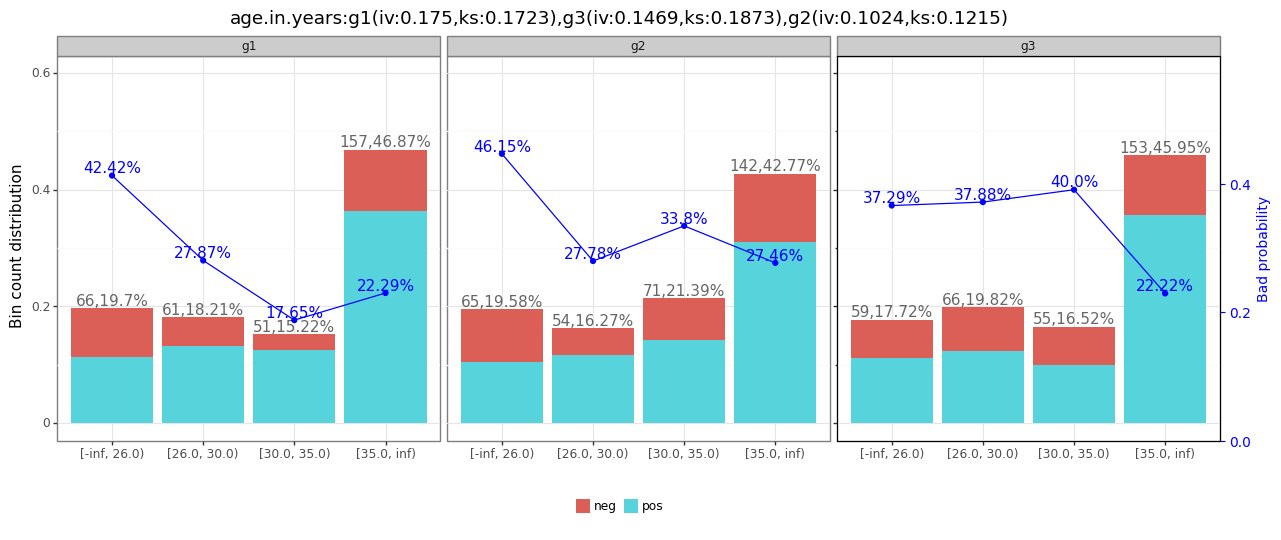

In [53]:
vtab_g_fig['age.in.years']

若希望在绘图报告中排序组水平，可使用参数sort_columns

geom_path: Each group consist of only one observation. Do you need to adjust the group aesthetic?


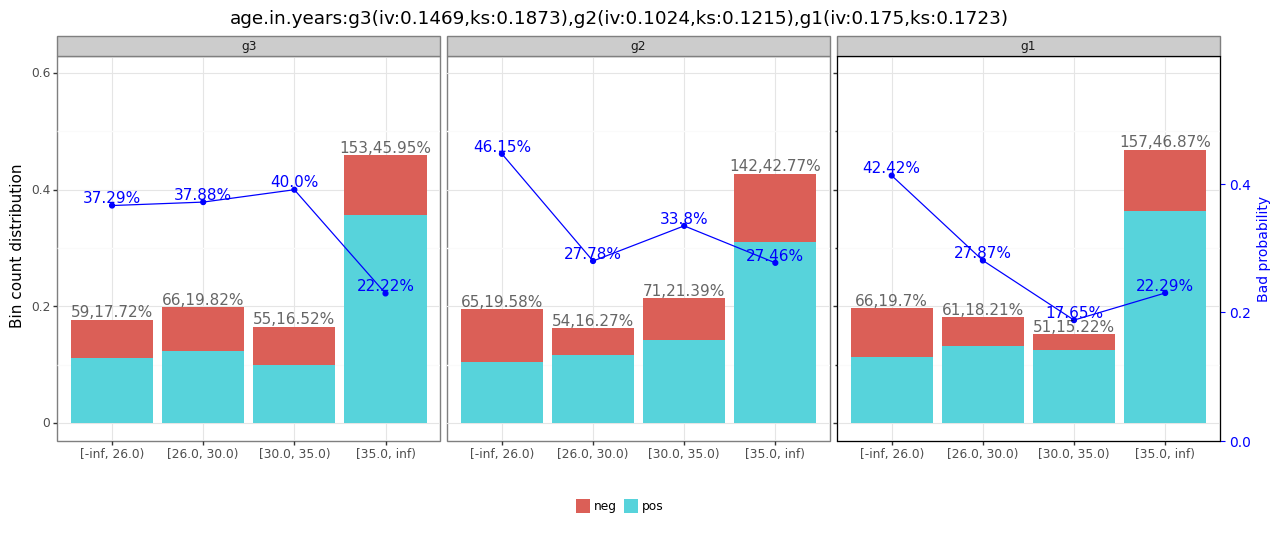

In [54]:
vtab_g_fig=varGroupsPlot(bin_tree.breaks_list,column='client_group',sort_column=['g3','g2','g1'],
                         target=y.name,n_jobs=1).plot(X_all,figure_size=(15,5))
vtab_g_fig['age.in.years']

### 1.4.8 导出为excel

varGroupsReport支持对组报告导出为excel,名称为var_report.xlsx

+ 参数out_path为报告输出路径,若无此路径则模块会创建该路径
+ 参数tab_suffix代表报告名称后缀,例如tab_suffix=‘_group’时,输出报告名称为var_report_group.xlsx
+ report_dict中所有的报告都会被导出,并写为不同的sheet

In [55]:
vtabs_g=bm.varGroupsReport(bin_tree.breaks_list,columns=['client_group'],
                           target=y.name,row_limit=0,
                           output_psi=True,n_jobs=1,
                           out_path='report/',
                           tab_suffix='_client'
                          ).fit(X_all)

to_excel done
